# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-Generating-Process" data-toc-modified-id="Data-Generating-Process-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Generating Process</a></div><div class="lev1 toc-item"><a href="#Variational-Bayes" data-toc-modified-id="Variational-Bayes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Variational Bayes</a></div>

In [1]:
%matplotlib inline

In [53]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.misc import logsumexp

In [3]:
os.chdir("/home/3928941380/Desktop/PMM/")

# Data Generating Process

`np.squeeze(np.asarray( ))`が多用されているのは、numpyでも(無理やり)縦ベクトルを基準としていて、関数に通すときにエラーが出るため

In [30]:
D = 2 # Data dimension
K = 4 # numbrt of mixture components
N = 200 # number of observation

alpha = 100 * np.mat(np.ones(K)[:, np.newaxis])
a = 1.0 *  np.ones(D)
b = 100

pi = np.mat(np.random.dirichlet(np.squeeze(np.asarray(alpha)))[:, np.newaxis])
lambda_ = np.mat([np.random.gamma(a, b) for i in range(K)])
z = np.mat(np.array([np.random.multinomial(1, np.squeeze(np.asarray(pi)), size=1) for i in range(N)])).T

data = np.mat(np.zeros((D, N)))
for i in range(N):
    lambda_d = lambda_.T * z[:,i]
    data[:, i] = np.mat(np.random.poisson(lam=np.squeeze(np.asarray(lambda_.T * z[:,i])), size=(1,2))).T

colorlist = ["r", "g", "b", "y", "c", "k", "m", "w"]
z_cat = []
for i in range(N):
    for k in range(K):
        if int(z[k, i]) == 1:
            z_cat.append(colorlist[k])

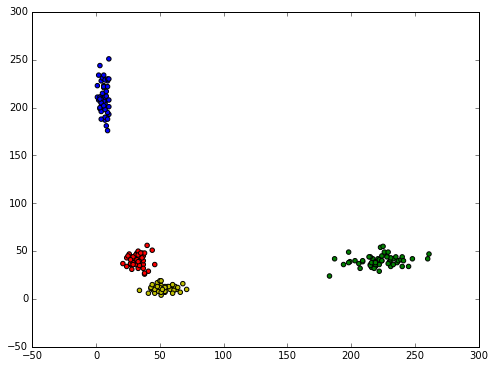

In [31]:
data_x = [] ; data_y = []
for i in range(N):
    data_x.append(data[0, i])
    data_y.append(data[1, i])

plt.rcParams['figure.figsize'] = (8, 6)
plt.scatter(data_x, data_y, c=z_cat)

# Variational Bayes

In [32]:
def return_cat(Z, i, K):
    for k in range(K):
        if int(Z[k, i]) == 1:
            return k

In [132]:
def updata_pi(alpha, Z, K):
    alpha_tmp = 100 * np.mat(np.ones(K)[:, np.newaxis])
    
    for k in range(K):
        alpha_tmp[k, 0] = alpha[k, 0] + z[k, :].sum()

    pi = np.mat(np.random.dirichlet(np.squeeze(np.asarray(alpha_tmp)))[:, np.newaxis])

    return pi

In [133]:
# initialization
D, N = data.shape
K = 4
alpha = 100 * np.mat(np.ones(K)[:, np.newaxis])
Z  = np.mat(np.array([np.random.multinomial(1, np.ones(K)/K, size=1) for i in range(N)])).T
lambda_ = np.mat([np.random.gamma(a, b)for i in range(K)])
pi = np.mat(np.random.rand(K,1))
pi /= pi.sum()

pi = updata_pi(alpha, Z, K)

In [147]:
#def update_lambda(a, b, data, lambda_, Z, D):
a_new = a + np.array([(data * Z.T)[d, k] for d in range(D)])
b_new = b + Z[k, :].sum()

In [158]:
np.random.gamma(a_new, b_new)

array([ 699845.72090924,  505099.64370757])

In [149]:
lambda_

matrix([[ 23.52594715,  12.20789603],
        [ 68.33872874,  76.6794996 ],
        [  0.3627499 ,  55.16537608],
        [ 79.98737419,  26.61912839]])

In [150]:
a

array([ 1.,  1.])

In [160]:
np.array([(data * Z.T)[d, k] for d in range(D)])

array([ 4510.,  3248.])

In [161]:
Z[k, :].sum()

52

In [152]:
a_new

array([ 4511.,  3249.])

In [153]:
b

100

In [154]:
b_new

152

In [157]:
Z[:,1]

matrix([[0],
        [0],
        [0],
        [1]])

In [144]:
np.array([(data * Z.T)[d, k] for d in range(D)])

array([ 4510.,  3248.])

In [135]:
Z.shape

(4, 200)

In [136]:
data.shape

(2, 200)

In [141]:
lambda_.shape

(4, 2)

In [137]:
a

array([ 1.,  1.])

In [128]:
updata_pi(alpha, Z, K)

matrix([[ 0.24789296],
        [ 0.25175165],
        [ 0.25525427],
        [ 0.24510112]])

In [126]:
z[k, :].sum()

43

In [122]:
alpha[k, 0]

100.0

In [99]:
#def update_z(data, K, lambda_, pi):
D, N = data.shape
Z_new = np.mat(np.zeros((K, N)))
pi_temp = np.mat(np.zeros((K, N)))
expsum_temp = np.mat(np.zeros((K, N)))

for n in range(N):
    for k in range(K):
        lambda_k = lambda_[k, :]
        
        for d in range(D):
            expsum_temp[k,n] += data[d, n] * np.log(lambda_[k, d]) - lambda_[k, d]

        pi_temp[k, n] = np.log(pi[k][0,0])  + expsum_temp[k,n]
    
    

In [115]:
lambda_[k, d]

279.95776052932746

In [112]:
pi_temp[:, n] - logsumexp(np.squeeze(np.asarray(pi_temp[:, 1])))

matrix([[   4.39214449],
        [ -23.08098759],
        [ -97.42682315],
        [-401.29553825]])

In [113]:
np.log(pi_temp[:, n] - logsumexp(np.squeeze(np.asarray(pi_temp[:, 1]))))

/home/3928941380/.conda/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


matrix([[ 1.4798176],
        [       nan],
        [       nan],
        [       nan]])

In [118]:
np.exp(pi_temp[:, n]) / np.exp(pi_temp[:, n]).sum()

matrix([[  1.00000000e+000],
        [  1.17103624e-012],
        [  6.03370673e-045],
        [  6.48750949e-177]])

In [108]:
logsumexp(np.squeeze(np.asarray(pi_temp[:, 1])))

149.35083167955017

In [56]:
logsumexp(np.squeeze(np.asarray(pi_temp)))

29526.20597011978

In [35]:
((data[:,i]  * np.log(lambda_[k, :])).sum(axis=0) + np.log(pi[k][0,0]))

matrix([[ 247.26608904,  258.11462655]])

In [47]:
np.log(pi[k][0,0])

-1.4647031144474385

In [44]:
data[:,i]

matrix([[ 52.],
        [ 10.]])

In [50]:
pi_temp

matrix([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]])

In [247]:
 + data[0,i] * np.log(lambda_[k, :]) + data[1,i] * np.log(lambda_[k, :])

matrix([[ 194.90026085,  147.05203592]])

In [41]:
np.exp(500)

1.4035922178528375e+217

In [243]:
lambda_k.T

matrix([[ 441.7009863],
        [  99.0253742]])

In [206]:
lambda_.shape

(4, 2)

In [255]:
np.log(pi[k][0,0])

-1.5613776356396178

In [211]:
lambda_[k, :]

matrix([[ 294.94353551,   29.64032245]])

In [214]:
data.shape

(2, 200)